## Expected Free Energy for oscillator with nonlinear observations

Wouter Kouw, last update: 20-11-2022

### System

Consider a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators) with displacement $x(t)$, driving force $u(t)$ and noise $w(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) + w(t)\, ,
\end{align*}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} 
$$
constitute the physical parameters. 

#### Multivariate first-order system

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u + \frac{1}{m} w \, .$$

With the variable substitution $z = [x \ x']$, I cast the above system into a multi-variate first-order form:

$$ \begin{bmatrix} x' \\ x'' \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w\, .$$

#### Discretization

For the Van Loan discretization of the Wiener process, I first consider a first-order approximation of the matrix exponential of the transition matrix: 

$$F(t) = I + \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} t \, .$$

Then, I will consider the continuous-time covariance matrix of the noise in multi-variate form:

$$\mathbb{V}[\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} w] = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} \mathbb{V}[w] \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}^{\top} = \begin{bmatrix} 0 & 0 \\ 0 & \frac{\sigma^2}{m^2} \end{bmatrix} \triangleq V \, .$$

Now, I can integrate the evolution of the covariance matrix from over the duration of a time-step. If all time-steps are equally long, e.g., of size $\Delta t$, then

$$Q = \int_0^{\Delta t} F(t) V F(t)^{\top} dt = \frac{\sigma^2}{m^2} \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} \\ \frac{-c}{m}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} & \frac{c^2}{m^2}\frac{\Delta t^3}{3} + \frac{\Delta t^2}{2} + \Delta t \end{bmatrix} \, ,$$

where $\sigma^2 = \mathbb{V}[w]$. A forward Euler discretization for the state transition yields:

$$\begin{align*} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} u_k \, ,
\end{align*}$$

So, we end up with:

$$\begin{align*}
z_k =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \frac{-k}{m} \Delta t & \frac{-c}{m} \Delta t + 1 \end{bmatrix}}_{A} z_{k-1} + \underbrace{\begin{bmatrix} 0 \\ \frac{1}{m} \Delta t \end{bmatrix}}_{B} u_k + q_k \quad \text{where} \quad q_k \sim \mathcal{N}(0,Q) \, .
\end{align*}$$

We have noisy observations of a nonlinear function $g$ of the displacement, 

$$ y_k = g(z_k) + r_k \quad \text{where} \quad r_k \sim \mathcal{N}(0, R) \, .$$

This gives an overall probabibilistic state-space model of the form:

$$\begin{align}
p(z_0) &= \mathcal{N}(z_0 \mid m_0, S_0) \\
p(z_k \mid z_{k-1}, u_k) &= \mathcal{N}(z_k \mid Az_{k-1} + Bu_k, Q) \\
p(y_k \mid z_k) &= \mathcal{N}(y_k \mid g(z_k), R) \, .
\end{align}$$

We can simulate the behaviour of this system as follows:

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/ECC2023-efe4ukf`


In [2]:
using Optim
using ForwardDiff
using ProgressMeter
using LinearAlgebra
# using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)

### Linear likelihood

In [32]:
# System parameters
mass = 1.0
friction = 0.5
stiffness = 0.5

# Temporal variables
Δt = 0.1
len_time = 200
time = range(0, step=Δt, length=len_time)

# Matrices
A = [1 Δt; -stiffness/mass*Δt -friction/mass*Δt+1]
B = [0, Δt/mass]
C = [1 0]

# Process noise
Q = 1.0/mass^2*[Δt^3/3 -friction/mass*Δt^3/3+Δt^2/2;-friction/mass*Δt^3/3+Δt^2/2 friction^2/mass^2*Δt^3/3+Δt^2/2+Δt]

# Observation noise
R(z) = dot([0,1],z)^2;

In [33]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = rand(MvNormal(A*z_kmin1 + B*u_k, Q))
    
    # Emit noisy observation
    y_k = rand(Normal(dot(C,z_k), sqrt(R(z_k))))
    
    return y_k, z_k
end;

In [34]:
# Control
u = [sin.(time[1:Int64(round(len_time/2))] .* 2/π); zeros(len_time-Int64(round(len_time/2)))];
# u = zeros(len_time)

In [35]:
# Initial state
state_0 = [0.0, 0.0]

# Preallocate
states = zeros(2,len_time)
observations = zeros(len_time)

# Start recursion
state_kmin1 = state_0
for k in 1:len_time
    
    # Update system
    observations[k], states[:,k] = update(state_kmin1, u[k])
    
    # Update recursion
    state_kmin1 = states[:,k]
    
end

In [37]:
R_k = cat([R(states[:,k]) for k in 1:len_time]..., dims=1);

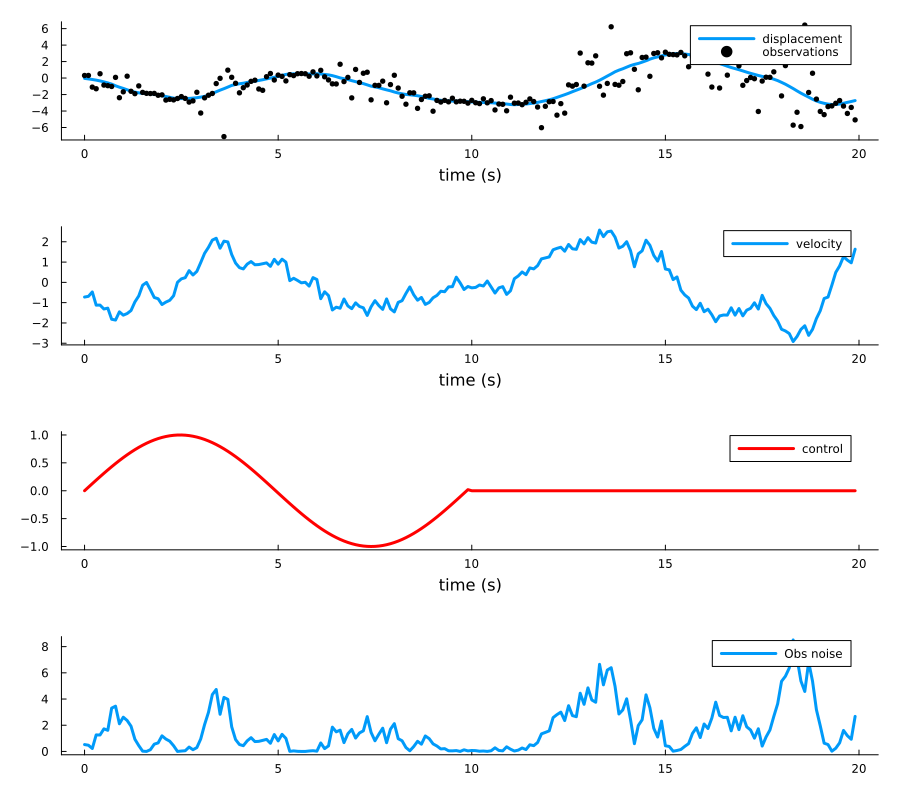

In [38]:
p1 = plot(time, states[1,:], xlabel="time (s)", label="displacement")
scatter!(time, observations, color="black", label="observations")
p2 = plot(time, states[2,:], xlabel="time (s)", label="velocity")
p3 = plot(time, u, color="red", xlabel="time (s)", label="control")
p4 = plot(time, R_k, label="Obs noise")
plot(p1, p2, p3, p4, layout=(4,1), size=(900,800))

In [41]:
# Number of iterations
n_iters = 10

# Preallocate
γ_est = (zeros(len_time), zeros(len_time))
z_est = (zeros(2,len_time), zeros(2,2,len_time))

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))
α_0 = 10.0
β_0 = 1.0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
α_kmin1 = α_0
β_kmin1 = β_0

@showprogress for k in 2:len_time
    
    m_ = m_kmin1
    S_ = S_kmin1
    α_ = α_kmin1
    β_ = β_kmin1
   
    for ii in 1:n_iters
    
        # Prediction step
        m_k_pred = A*m_kmin1 + B*u[k]
        S_k_pred = A*S_kmin1*A' + Q
        C_k_pred = A*S_kmin1

        # Correction step
        Kg = S_k_pred*(C*inv(dot(C*S_k_pred,C) + R(m_k_pred)))'
        m_ = m_k_pred + Kg*(observations[k] - dot(C,m_k_pred))
        S_ = (diagm(ones(2)) - Kg*C)*S_k_pred

        # Update noise precision
        α_ = α_kmin1 + 3/2
        β_k = β_kmin1 + 3/2
        
    end
    
    # Store state estimates
    z_est[1][:,k] = m_
    z_est[2][:,:,k] = S_
    γ_est[1][k] = α_
    γ_est[2][k] = β_
   
    # Update recursion
    m_kmin1 = m_
    S_kmin1 = S_
    α_kmin1 = α_
    β_kmin1 = β_
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


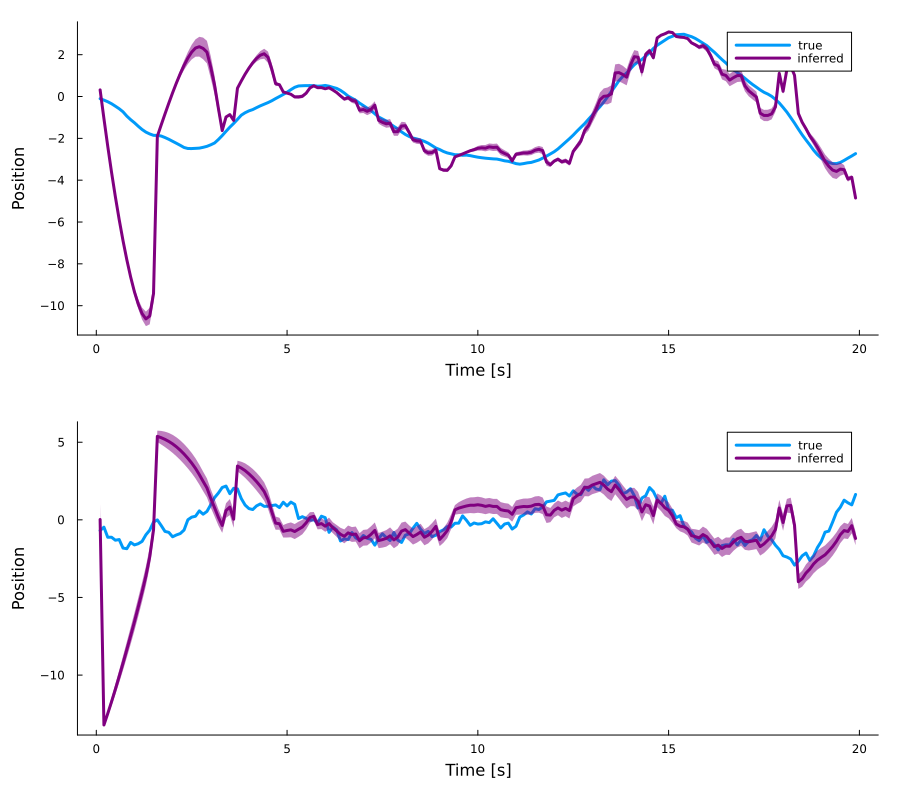

In [42]:
p201 = plot(time[2:end], states[1,2:end], label="true", ylabel="Position", xlabel="Time [s]")
# plot!(time[2:end], z_est[1][1,2:end], label="inferred", color="purple")
plot!(time[2:end], z_est[1][1,2:end], ribbon=z_est[2][1,1,2:end], label="inferred", color="purple")

p202 = plot(time[2:end], states[2,2:end], label="true", ylabel="Position", xlabel="Time [s]")
# plot!(time[2:end], z_est[1][2,2:end], label="inferred", color="purple")
plot!(time[2:end], z_est[1][2,2:end], ribbon=z_est[2][2,2,2:end], label="inferred", color="purple")

plot(p201, p202, layout=(2,1), size=(900,800))

### Nonlinear likelihood

In [43]:
# System parameters
m = 3.0
c = 0.9
k = 2.0

# Temporal variables
Δt = 0.1
len_time = 200
time = range(0, step=Δt, length=len_time)

# Matrices
A = [1 Δt; -k/m*Δt -c/m*Δt+1]
B = [0, Δt/m]
C = [1 0]

# Process noise
Q = 1/m^2*[Δt^3/3 -c/m*Δt^3/3+Δt^2/2;-c/m*Δt^3/3+Δt^2/2 c^2/m^2*Δt^3/3+Δt^2/2+Δt]

# Observation noise
R(z) = dot([0,1], z)^2;

# Nonlinear observation
beacon = 3.0
g(z) = sqrt(([1.0, 0.0]'*z - beacon)^2)

g (generic function with 1 method)

In [44]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = rand(MvNormal(A*z_kmin1 + B*u_k, Q))
    
    # Emit noisy observation
    y_k = rand(Normal(g(z_k), sqrt(R(z_k))))
    
    return y_k, z_k
end;

In [45]:
# Control
u = [sin.(time[1:Int64(round(len_time/2))] .* 2/π); zeros(len_time-Int64(round(len_time/2)))];
# u = zeros(len_time)

In [46]:
# Initial state
state_0 = [0.0, 0.0]

# Preallocate
states = zeros(2,len_time)
observations = zeros(len_time)

# Start recursion
state_kmin1 = state_0
for k in 1:len_time
    
    # Update system
    observations[k], states[:,k] = update(state_kmin1, u[k])
    
    # Update recursion
    state_kmin1 = states[:,k]
    
end

In [48]:
R_k = cat([R(states[:,k]) for k in 1:len_time]..., dims=1);

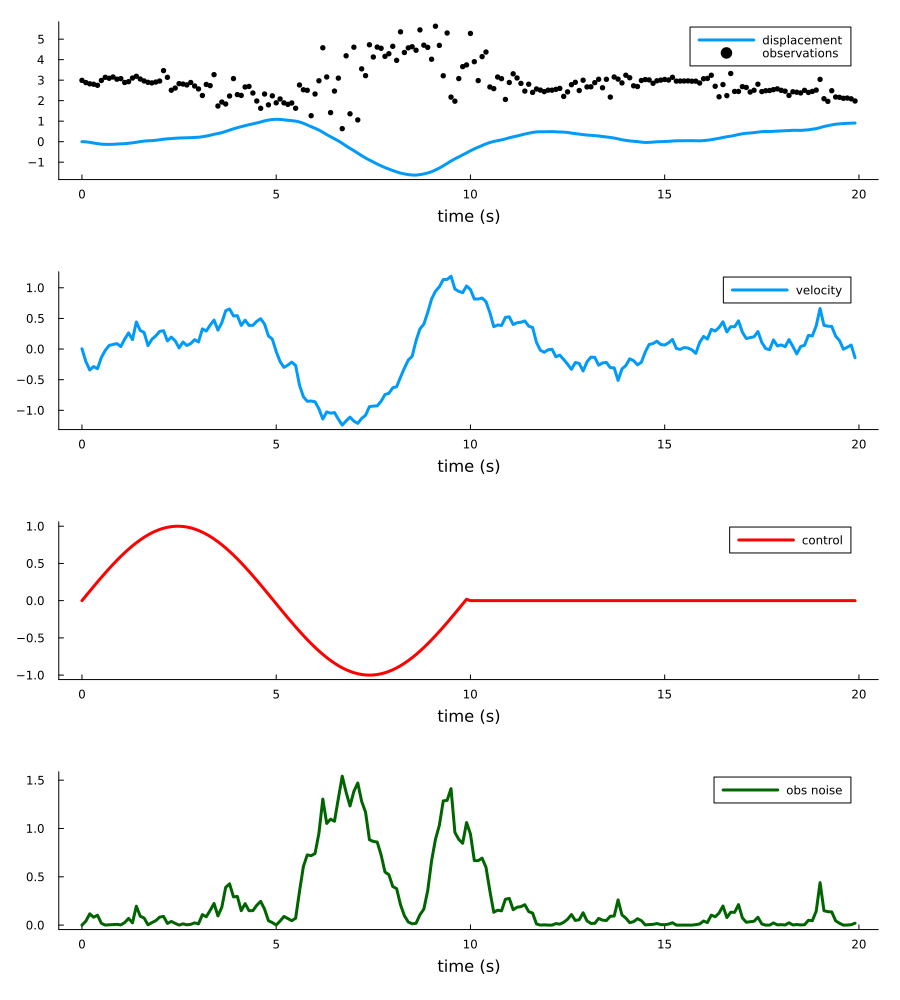

In [50]:
p1 = plot(time, states[1,:], xlabel="time (s)", label="displacement")
scatter!(time, observations, color="black", label="observations")
p2 = plot(time, states[2,:], xlabel="time (s)", label="velocity")
p3 = plot(time, u, color="red", xlabel="time (s)", label="control")
p4 = plot(time, R_k, color="darkgreen", xlabel="time (s)", label="obs noise")
plot(p1, p2, p3, p4, layout=(4,1), size=(900,1000))

In [51]:
function sigma_points(m,P; α=1e-3, κ=0.0)
    
    # Number of sigma points depends on dimensionality
    N = size(P,2)
    
    # Compute scaling parameter
    λ = α^2*(N+κ)-N
    
    # Square root of cov
    sP = sqrt(P)
    
    # Preallocate
    sigma = zeros(eltype(m),N,2N+1)
    
    # First point is mean
    sigma[:,1] = m
    
    # Positive
    for n = 1:N
        sigma[:,1+n] = m + sqrt(N+λ)*sP[:,n]
    end
            
    # Negative
    for n = 1:N
        sigma[:,1+N+n] = m - sqrt(N+λ)*sP[:,n]
    end
    
    return sigma
end

function ut_weights(; α=1e-3, β=2.0, κ=0.0, N=1)
    
    # Compute scaling parameter
    λ = α^2*(N+κ)-N
    
    # Preallocate
    Wm = zeros(2N+1)
    Wc = zeros(2N+1)
    
    # Zero-order weights
    Wm[1] = λ/(N+λ)
    Wc[1] = λ/(N+λ) + (1-α^2+β)
    
    for n = 2:(2N+1)
        Wm[n] = 1/(2(N+λ))
        Wc[n] = 1/(2(N+λ))
    end
    return Wm,Wc
end

function UT(m::AbstractVector{T}, P, g, Q; α=1e-3, β=2.0, κ=0.0) where T
    "Algorithm 5.12 in 'Bayesian filtering & smoothing'"
    
    # Number of sigma points depends on dimensionality
    N = size(P,2)
    
    # Form sigma points
    σ = sigma_points(m,P, α=α, κ=κ)
    
    # Propagate sigma points through non-linearity
    y = [g(σ[:,i]) for i in 1:size(σ,2)]
    
    # Compute constant weigths
    Wm, Wc = ut_weights(α=α, β=β, κ=κ, N=N)
    
    # Compute moments of approximated distribution
    μ = sum([Wm[i]* y[i] for i in 1:(2N+1)])
    Σ = sum([Wc[i]*(y[i] - μ)*(y[i] - μ)' for i in 1:(2N+1)])
    C = sum([Wc[i]*(σ[:,i] - m)*(y[i] - μ)' for i in 1:(2N+1)])
    
    if Q != nothing; Σ += Q; end
    return μ,Σ,C
end

UT (generic function with 1 method)

In [52]:
# Preallocate
z_est = (zeros(2,len_time), zeros(2,2,len_time))

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

@showprogress for k in 2:len_time
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u[k]
    S_k_pred = A*S_kmin1*A' + (β_kmin1/α_kmin1)*Q
    C_k_pred = A*S_kmin1

    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, R(m_k_pred))
    K_t = CU*inv(SU)
    m_k = m_k_pred + K_t*(observations[k] - mU)
    S_k = S_k_pred - K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

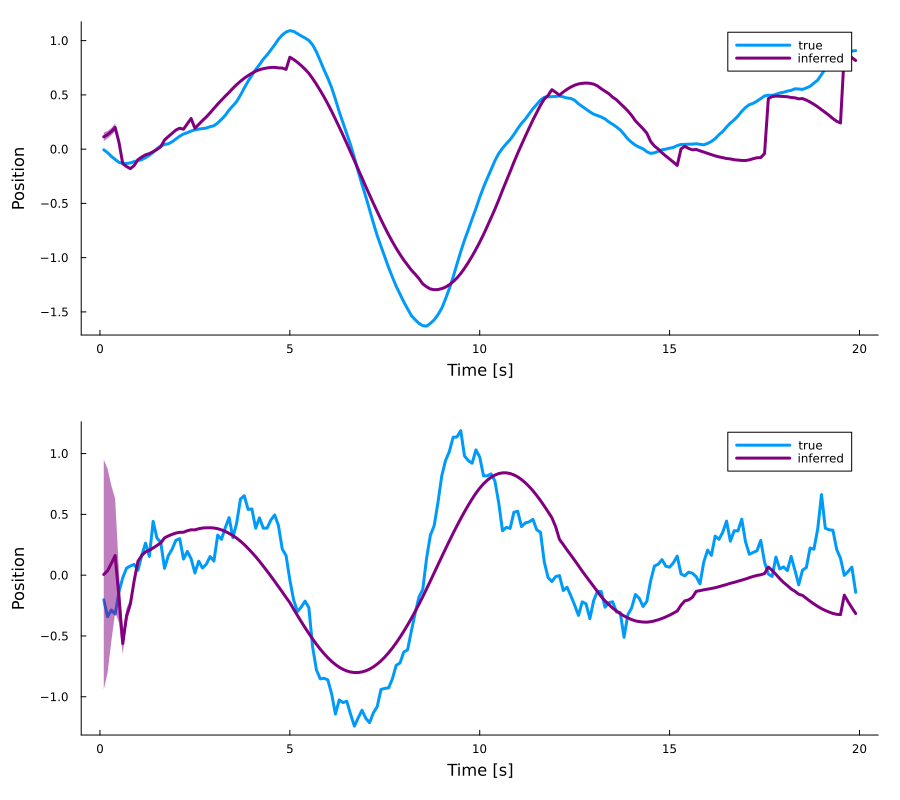

In [53]:
p201 = plot(time[2:end], states[1,2:end], label="true", ylabel="Position", xlabel="Time [s]")
# plot!(time[2:end], z_est[1][1,2:end], label="inferred", color="purple")
plot!(time[2:end], z_est[1][1,2:end], ribbon=z_est[2][1,1,2:end], label="inferred", color="purple")

p202 = plot(time[2:end], states[2,2:end], label="true", ylabel="Position", xlabel="Time [s]")
# plot!(time[2:end], z_est[1][2,2:end], label="inferred", color="purple")
plot!(time[2:end], z_est[1][2,2:end], ribbon=z_est[2][2,2,2:end], label="inferred", color="purple")

plot(p201, p202, layout=(2,1), size=(900,800))